In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.cluster import KMeans
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Naive Bayes Classifiers, Random Forest and Support Vector Machines algorithms. 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

from sklearn.base import TransformerMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV


from tqdm import tqdm

In [2]:
data = pd.read_csv("data/CompleteDataset.csv", low_memory=False).drop(columns=["Unnamed: 0"]).dropna()
data = data.drop(columns=['Photo', 'Flag', 'Club Logo'])
data.head()

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Acceleration,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,Cristiano Ronaldo,32,Portugal,94,94,Real Madrid CF,€95.5M,€565K,2228,89,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,L. Messi,30,Argentina,93,93,FC Barcelona,€105M,€565K,2154,92,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,Neymar,25,Brazil,92,94,Paris Saint-Germain,€123M,€280K,2100,94,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,L. Suárez,30,Uruguay,92,92,FC Barcelona,€97M,€510K,2291,88,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
5,R. Lewandowski,28,Poland,91,91,FC Bayern Munich,€92M,€355K,2143,79,...,58.0,57.0,78.0,62.0,87.0,82.0,88.0,84.0,61.0,88.0


In [ ]:
def value_to_float(x):
    x.split('€')[1]
    if type(x) == float or type(x) == int:
        return x
    if 'M' in x:
        return float(x.split('€')[1].replace('M','')) * 1000000
    if 'K' in x:
        return float(x.split('€')[1].replace('K','')) * 1000
    if '€' in x:
        return float(x.split('€')[1])
    return 0

def clean_stat(value):
    try:
        if '+' in value or '-' in value:
            base, mod = value.split('+') if '+' in value else value.split('-')
            mod = int(mod) if '+' in value else -int(mod)
            return int(base) + mod
        else:
            return int(value)
    except:
        return np.nan
    

def create_features(data):

    df = data.copy()

    columns_with_issues = ['Finishing', 'Composure', 'Dribbling', 'Shot power', 
                        'Standing tackle', 'Marking', 'Interceptions', 'Strength', 
                        'Stamina', 'Jumping', 'Ball control', 'Short passing']

    for c in columns_with_issues:
        df[c] = df[c].apply(clean_stat)

    df['Value'] = df['Value'].apply(value_to_float)
    df['Wage'] = df['Wage'].apply(value_to_float)

    df['Primary Position'] = df['Preferred Positions'].apply(lambda x: x.split()[0])
    df['Secondary Positions'] = df['Preferred Positions'].apply(lambda x: ' '.join(x.split()[1:]))

    df['Attacking Score'] = df[['Finishing', 'Dribbling', 'Shot power']].mean(axis=1)
    df['Defensive Score'] = df[['Standing tackle', 'Marking', 'Interceptions']].mean(axis=1)

    df['Attack/Defend Ratio'] = df['Attacking Score'] / df['Defensive Score']

    df['isAttacker'] = np.where(df['Attack/Defend Ratio'] > 1, 1.0, 0.0)

    df['Physical Index'] = df[['Strength', 'Stamina', 'Jumping']].mean(axis=1)
    df['Technical Skill'] = df[['Ball control', 'Dribbling', 'Short passing']].mean(axis=1)

    df['Value per Overall'] = df['Value'] / df['Overall']
    df['Wage per Overall'] = df['Wage'] / df['Overall']
    df['Potential Gap'] = df['Potential'] - df['Overall']

    df['Age Group'] = pd.cut(df['Age'], bins=[15, 20, 25, 30, 40, 50], labels=['Teen', 'Young', 'Prime', 'Veteran', 'Legend'])
    df['Scoring Under Pressure'] = df['Finishing'] * df['Composure']
    df['GK Score'] = df[['GK diving', 'GK reflexes', 'GK positioning']].mean(axis=1)


    # kmeans = KMeans(n_clusters=5, random_state=0)
    # df['Player Archetype'] = kmeans.fit_predict(df[['Overall', 'Potential', 'Value', 'Wage', 'Age']])

    df.drop_duplicates(inplace=True)

    return df.reset_index(drop=True)

df = create_features(data)
df.head(3)

c:\Users\vince\.conda\envs\env_dev_1\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vince\.conda\envs\env_dev_1\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\vince\.conda\envs\env_dev_1\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Acceleration,...,isAttacker,Physical Index,Technical Skill,Value per Overall,Wage per Overall,Potential Gap,Age Group,Scoring Under Pressure,GK Score,Player Archetype
0,Cristiano Ronaldo,32,Portugal,94,94,Real Madrid CF,95500000.0,565000.0,2228,89,...,1.0,89.000000,89.000000,1.015957e+06,6010.638298,0,Veteran,8930,23704.666667,1
1,L. Messi,30,Argentina,93,93,FC Barcelona,105000000.0,565000.0,2154,92,...,1.0,66.666667,93.333333,1.129032e+06,6075.268817,0,Prime,9120,2271.333333,1
2,Neymar,25,Brazil,92,94,Paris Saint-Germain,123000000.0,280000.0,2100,94,...,1.0,64.000000,90.666667,1.336957e+06,3043.478261,2,Young,8188,30371.666667,1


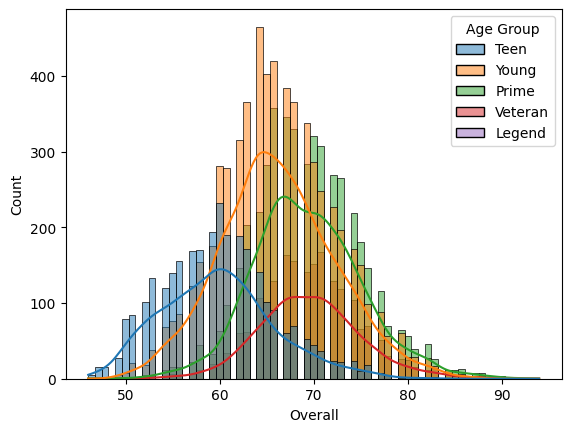

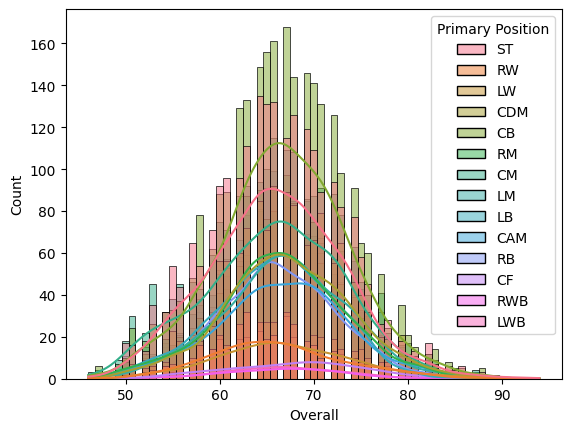

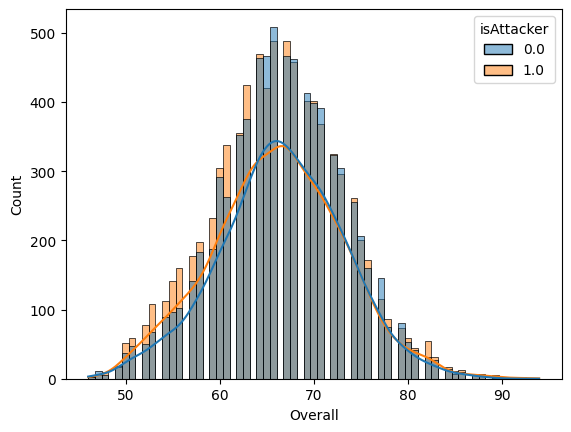

In [4]:
# Class imbalance
sns.histplot(data=df, x='Overall', hue='Age Group', kde=True)
plt.show()

sns.histplot(data=df, x='Overall', hue='Primary Position', kde=True)
plt.show()

sns.histplot(data=df, x='Overall', hue='isAttacker', kde=True)
plt.show()

In [ ]:
target = 'isAttacker'
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'int32', 'float64']).columns
try:
    categorical_cols = categorical_cols.drop(target)
except:
    pass
try:
    numerical_cols = numerical_cols.drop(target)
except:
    pass

subset_frac = 1.0

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=target).sample(frac=subset_frac, random_state=42), 
                                                    df[target].sample(frac=subset_frac, random_state=42), 
                                                    stratify=df[target].sample(frac=subset_frac, random_state=42), random_state=42)



# from collections import Counter
# min_class_samples = min(Counter(y_train).values())
# k_neighbors = max(1, min_class_samples - 1)
# smote = SMOTE(random_state=42, k_neighbors=k_neighbors)



In [9]:
# CORRELATION WITH TARGET
correlation = df.corr()[target].sort_values(ascending=False)
correlation = correlation.drop(target)
correlation

C:\Users\vince\AppData\Local\Temp\ipykernel_35596\3729890613.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()[target].sort_values(ascending=False)


Finishing                 0.727947
Attack/Defend Ratio       0.712929
Attacking Score           0.635394
Scoring Under Pressure    0.588571
LS                        0.533580
ST                        0.533580
RS                        0.533580
CF                        0.528317
RF                        0.528317
LF                        0.528317
RW                        0.503622
LW                        0.503622
Dribbling                 0.488946
LAM                       0.469695
CAM                       0.469695
RAM                       0.469695
Shot power                0.421511
LM                        0.415280
RM                        0.415280
Technical Skill           0.360496
Ball control              0.347891
LCM                       0.140003
RCM                       0.140003
CM                        0.140003
Short passing             0.109064
Special                   0.081473
Potential Gap             0.077708
Composure                 0.073771
Value per Overall   

C:\Users\vince\AppData\Local\Temp\ipykernel_35596\3907592428.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.clustermap(df.corr(), cmap='coolwarm', center=0, linewidths=0.75, figsize=(15, 15))


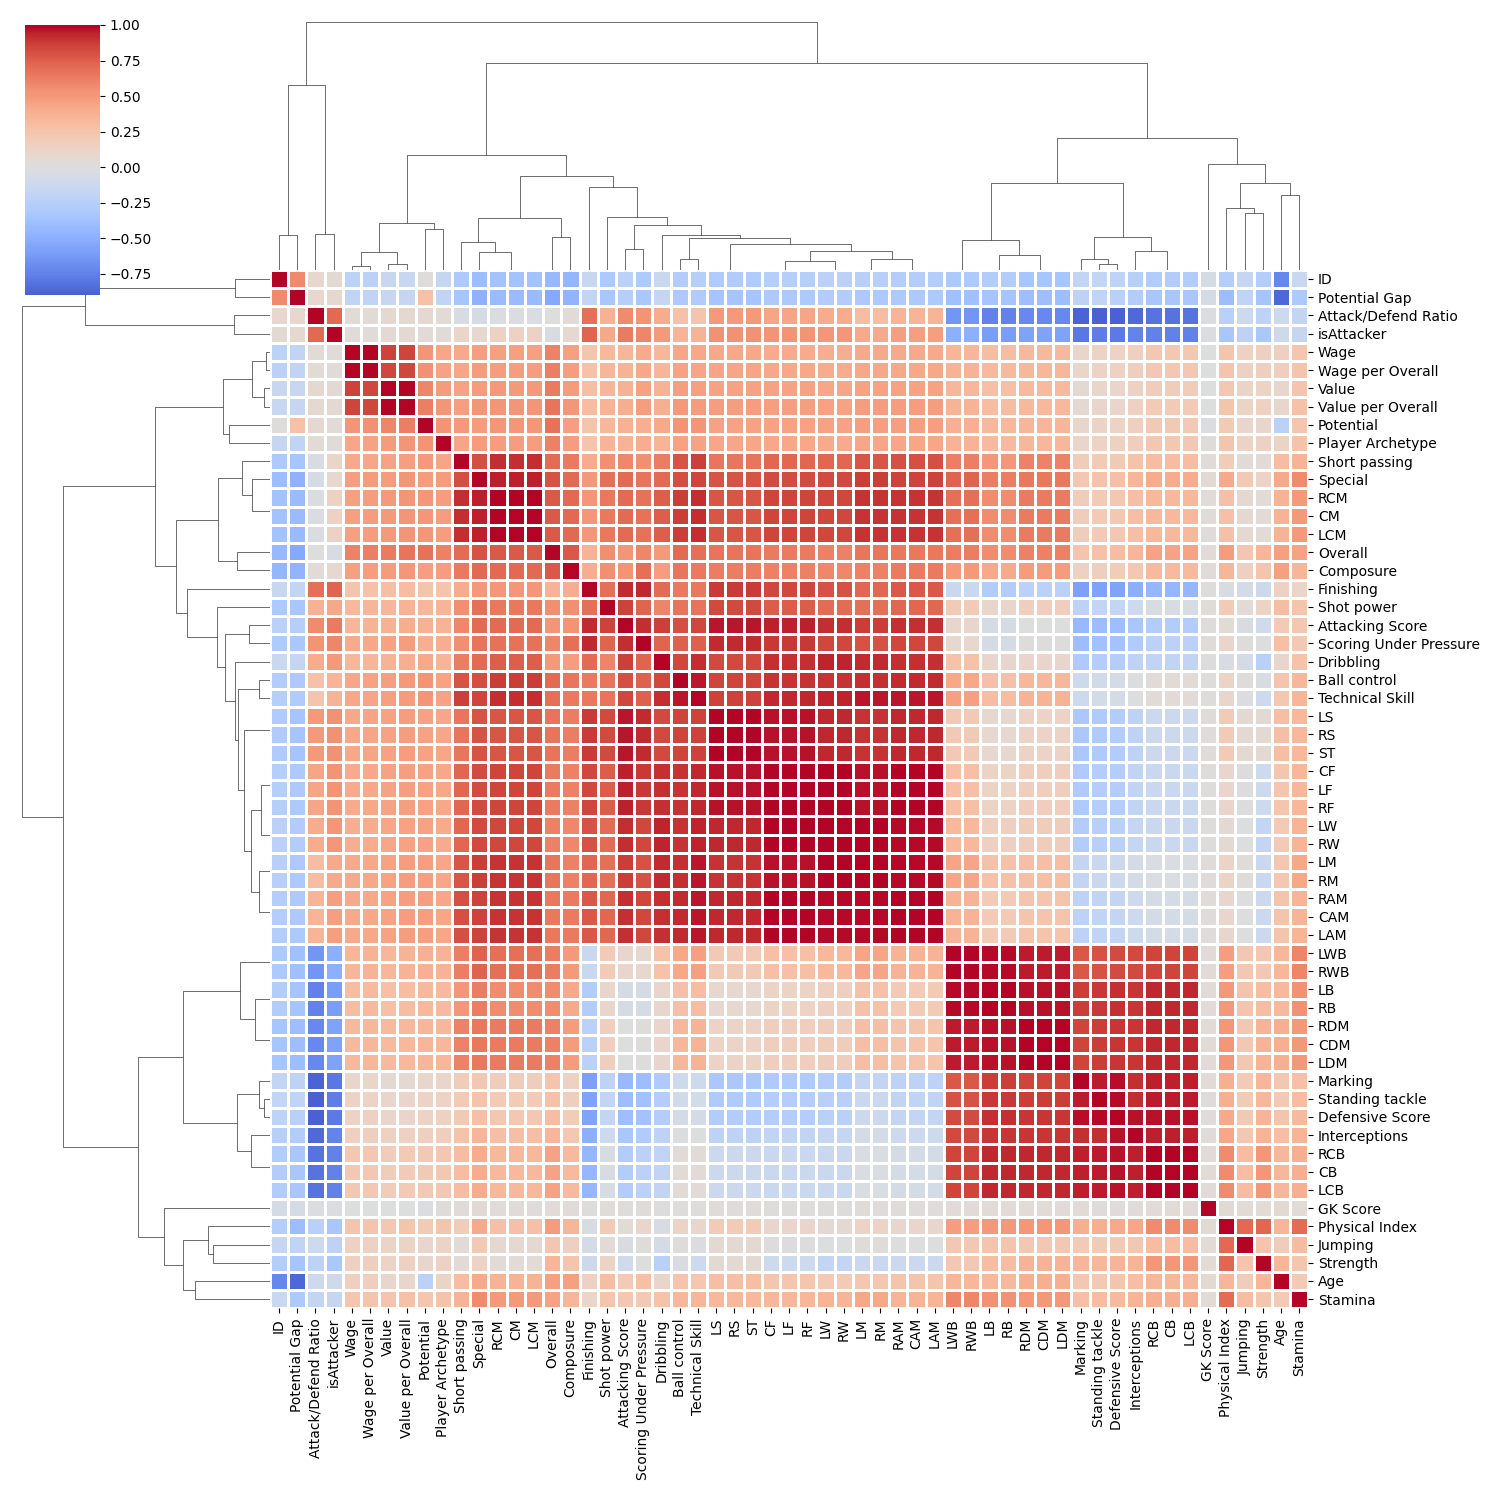

In [10]:
# HIERARCHICAL CLUSTERING CORRELATION
sns.clustermap(df.corr(), cmap='coolwarm', center=0, linewidths=0.75, figsize=(15, 15))
plt.show()

In [ ]:
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    # ('smote', smote),
    ('classifier', RandomForestClassifier(random_state=42))
])

classifiers = [
    RandomForestClassifier(random_state=42),
    LogisticRegression(max_iter=1000, random_state=42),
    GaussianNB(),
    SVC(random_state=42)
]

for clf in tqdm(classifiers):
    pipeline.set_params(classifier=clf)
    try:
        scores = cross_val_score(
            pipeline, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1
        )
        print(f'{clf.__class__.__name__} Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})')
    except Exception as e:
        print(f"Error with {clf.__class__.__name__}: {e}")

param_grid = [
    {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20]
    },
    {
        'classifier': [LogisticRegression(max_iter=1000, random_state=42)],
        'classifier__C': [0.1, 1, 10]
    },
    {
        'classifier': [GaussianNB()]
    },
    {
        'classifier': [SVC(random_state=42)],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    }
]

grid_search = GridSearchCV(
    pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, error_score='raise'
)

try:
    grid_search.fit(X_train, y_train)
    print(f'Best classifier: {grid_search.best_estimator_.named_steps["classifier"]}')
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best cross-validation score: {grid_search.best_score_:.2f}')
except Exception as e:
    print(f"Grid search error: {e}")


 25%|██▌       | 1/4 [00:05<00:16,  5.38s/it]

RandomForestClassifier Accuracy: 0.99 (+/- 0.01)


 50%|█████     | 2/4 [00:11<00:11,  5.92s/it]

LogisticRegression Accuracy: 0.99 (+/- 0.00)


 75%|███████▌  | 3/4 [00:13<00:03,  3.92s/it]

GaussianNB Accuracy: 0.86 (+/- 0.01)


100%|██████████| 4/4 [00:34<00:00,  8.74s/it]

SVC Accuracy: 0.98 (+/- 0.00)


Best classifier: RandomForestClassifier(n_estimators=200, random_state=42)
Best parameters: {'classifier': RandomForestClassifier(random_state=42), 'classifier__max_depth': None, 'classifier__n_estimators': 200}
Best cross-validation score: 0.99


In [ ]:
import smogn

def apply_smogn(X_train, y_train, target):
    data = X_train.copy()
    data[target] = y_train
    data.reset_index(drop=True, inplace=True)
    data = data.select_dtypes(include=['number'])
    data_smogn = smogn.smoter(
        data=data,
        y=target,
        k=3,
        samp_method='extreme',
        rel_thres=0.80,
        rel_method='auto',
        rel_xtrm_type='both',
        rel_coef=2.25
    )

    X_train_smogn = data_smogn.drop(columns=[target])
    y_train_smogn = data_smogn[target]
    return X_train_smogn, y_train_smogn

X_train_smogn, y_train_smogn = apply_smogn(X_train, y_train, target='Value')


In [ ]:
X_train_smogn